# Solution with content-based filtering

## Customization and import

In [3]:
import random
import re

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import requests
import tensorflow as tf
from IPython.core.display import HTML
from nltk.corpus import stopwords
from PIL import Image
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, MinMaxScaler,
                                   StandardScaler)
from sklearn.utils import estimator_html_repr
from tensorflow import keras
from tensorflow.keras import callbacks, layers, models, optimizers, utils

## Data

In [4]:
ratings = pd.read_csv("Ratings.csv")

In [5]:
print(ratings.shape)
ratings.head()

(1149780, 3)


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [6]:
items = pd.read_csv("Books.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
print(items.shape)
items.head(5)

(271360, 8)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
items["Year-Of-Publication"] = (
    items["Year-Of-Publication"]
    .replace("DK Publishing Inc", np.nan)
    .replace("Gallimard", np.nan)
    .astype(float)
)

In [8]:
users = pd.read_csv("Users.csv")
print(users.shape)
users.head()

(278858, 3)


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
ratings_merged = (
    ratings.merge(ratings, how="left").merge(items, how="left").merge(users, how="left")
)
print(ratings_merged.shape)
ratings_merged.head()

(1149780, 12)


,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Location,Age
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,"tyler, texas, usa",NaN
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001.0,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,"seattle, washington, usa",NaN
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996.0,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,"h, new south wales, australia",16.0
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,"rijeka, n/a, croatia",16.0
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,"rijeka, n/a, croatia",16.0


In [ ]:
ITEM_FEATURES = ["Book-Title", "Book-Author", "Year-Of-Publication", "Publisher"]
USER_FEATURES = ["Location", "Age"]
TARGET = ["Book-Rating"]

x_item = ratings_merged[ITEM_FEATURES]
x_user = ratings_merged[USER_FEATURES]
y = ratings_merged[TARGET]

x_item.shape, x_user.shape, y.shape

((1149780, 4), (1149780, 2), (1149780, 1))

## Preprocessing

In [ ]:
def get_2d_to_1d(df):
    return df.reshape(-1)


impute_blanks = lambda: SimpleImputer(strategy="constant", fill_value="")
impute_median = lambda: SimpleImputer(strategy="median")

reshape = lambda: FunctionTransformer(get_2d_to_1d)

tfidf = lambda: TfidfVectorizer(analyzer="char", ngram_range=(2, 2))
scale = lambda: StandardScaler()

preprocessor_items = ColumnTransformer(
    [
        (
            "Book-Title",
            Pipeline(
                [
                    ("impute", impute_blanks()),
                    ("reshape", reshape()),
                    ("encoder", tfidf()),
                ]
            ),
            ["Book-Title"],
        ),
        (
            "Book-Author",
            Pipeline(
                [
                    ("impute", impute_blanks()),
                    ("reshape", reshape()),
                    ("encoder", tfidf()),
                ]
            ),
            ["Book-Author"],
        ),
        (
            "Year-Of-Publication",
            Pipeline([("impute", impute_median()), ("encoder", scale())]),
            ["Year-Of-Publication"],
        ),
        (
            "Publisher",
            Pipeline(
                [
                    ("impute", impute_blanks()),
                    ("reshape", reshape()),
                    ("encoder", tfidf()),
                ]
            ),
            ["Publisher"],
        ),
    ]
)

preprocessor_users = ColumnTransformer(
    [
        (
            "Location",
            Pipeline(
                [
                    ("impute", impute_blanks()),
                    ("reshape", reshape()),
                    ("encoder", tfidf()),
                ]
            ),
            ["Location"],
        ),
        ("Age", Pipeline([("impute", impute_median()), ("encoder", scale())]), ["Age"]),
    ]
)

ratings_scaler = MinMaxScaler()

x_item = preprocessor_items.fit_transform(x_item)
x_user = preprocessor_users.fit_transform(x_user)
y = ratings_scaler.fit_transform(y).reshape(-1)

x_item.shape, x_user.shape

((1149780, 5571), (1149780, 1695))

In [ ]:
HTML(estimator_html_repr(preprocessor_items))

In [ ]:
HTML(estimator_html_repr(preprocessor_users))

In [ ]:
def sparse_array_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

In [ ]:
x_item = sparse_array_to_sparse_tensor(x_item)
x_user = sparse_array_to_sparse_tensor(x_user)
y = y

## Networks

In [ ]:
items_input = layers.Input(shape=(x_item.shape[1]))
items_ = layers.Dense(32, activation="relu")(items_input)
items_vector = layers.Dense(32, activation="relu")(items_)

users_input = layers.Input(shape=(x_user.shape[1]))
users_ = layers.Dense(32, activation="relu")(users_input)
users_vector = layers.Dense(32, activation="relu")(users_)

items_norm = tf.linalg.l2_normalize(items_vector, axis=1)
users_norm = tf.linalg.l2_normalize(users_vector, axis=1)

output = layers.Dot(axes=1)([items_norm, users_norm])

model = models.Model([items_input, users_input], output)

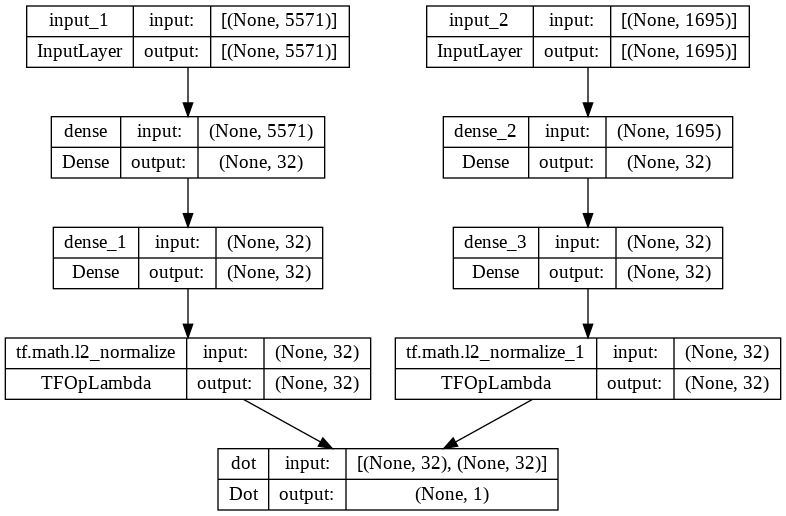

In [ ]:
utils.plot_model(model, show_shapes=True, expand_nested=True)

In [ ]:
model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(1e-4))
model.summary()

es = callbacks.EarlyStopping(
    monitor="loss", patience=5, verbose=1, restore_best_weights=True
)
rlp = callbacks.ReduceLROnPlateau(monitor="loss", patience=2, verbose=1)

model.fit([x_item, x_user], y, callbacks=[es, rlp], batch_size=32, epochs=55)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5571)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1695)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 32)           178304      ['input_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 32)           54272       ['input_2[0][0]']                
                                                                                              

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dense_2/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dense_2/embedding_lookup_sparse/Reshape:0", shape=(None, 32), dtype=float32), dense_shap

35931/35931 [==============================] - 204s 5ms/step - loss: 0.1304 - lr: 1.0000e-04
Epoch 2/55
35931/35931 [==============================] - 190s 5ms/step - loss: 0.1239 - lr: 1.0000e-04
Epoch 3/55
35931/35931 [==============================] - 186s 5ms/step - loss: 0.1214 - lr: 1.0000e-04
Epoch 4/55
35931/35931 [==============================] - 187s 5ms/step - loss: 0.1196 - lr: 1.0000e-04
Epoch 5/55
35931/35931 [==============================] - 186s 5ms/step - loss: 0.1182 - lr: 1.0000e-04
Epoch 6/55
35931/35931 [==============================] - 186s 5ms/step - loss: 0.1170 - lr: 1.0000e-04
Epoch 7/55
35931/35931 [==============================] - 183s 5ms/step - loss: 0.1160 - lr: 1.0000e-04
Epoch 8/55
35931/35931 [==============================] - 188s 5ms/step - loss: 0.1152 - lr: 1.0000e-04
Epoch 9/55
35931/35931 [==============================] - 185s 5ms/step - loss: 0.1145 - lr: 1.0000e-04
Epoch 10/55
35931/35931 [==============================] - 182s 5ms/step - 

## Saving the models

In [ ]:
model_items = models.Model(items_input, items_vector)
model_users = models.Model(users_input, users_vector)

joblib.dump(preprocessor_items, "preprocessor_items.bin")
joblib.dump(preprocessor_users, "preprocessor_users.bin")

model_items.save("model_items.h5")
model_users.save("model_users.h5")
model.save("model.h5")

In [ ]:
input_items_vec = layers.Input(shape=(32))
norm_items = tf.linalg.l2_normalize(input_items_vec, axis=1)
input_users_vec = layers.Input(shape=(32))
norm_users = tf.linalg.l2_normalize(input_users_vec, axis=1)
output = layers.Dot(axes=1)([norm_items, norm_users])
dot_model = models.Model([input_items_vec, input_users_vec], output)
dot_model.save("dot_model.h5")

## Getting Recommendations

In [ ]:
new_user = pd.DataFrame({"Location": ["new delhi, india"], "Age": [25]})
new_user_preprocessed = preprocessor_users.transform(new_user)
new_user_vector = model_users.predict(new_user_preprocessed)
new_user_vector.shape

1/1 [==============================] - 0s 87ms/step


(1, 32)

In [ ]:
all_item_preprocessed = preprocessor_items.transform(items[ITEM_FEATURES])
all_item_vector = model_items.predict(all_item_preprocessed)
all_item_vector.shape

8480/8480 [==============================] - 16s 2ms/step


(271360, 32)

In [ ]:
new_user_vector = np.broadcast_to(new_user_vector, all_item_vector.shape)
preds = dot_model.predict([new_user_vector, all_item_vector])
items["preds"] = preds

8480/8480 [==============================] - 10s 1ms/step


## Recommendations

In [ ]:
items.sort_values("preds", ascending=False).head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,preds
89361,0840791992,It Happened at the Sunset Grille,Will Cunningham,1993.0,Oliver-Nelson Books,http://images.amazon.com/images/P/0840791992.0...,http://images.amazon.com/images/P/0840791992.0...,http://images.amazon.com/images/P/0840791992.0...,0.998555
160570,0933124007,Goobersville Breakdown,Robert Lieberman,1979.0,Gamma Books,http://images.amazon.com/images/P/0933124007.0...,http://images.amazon.com/images/P/0933124007.0...,http://images.amazon.com/images/P/0933124007.0...,0.985014
247448,0152339000,Hey-How for Halloween!,Lee Bennett Hopkins,1974.0,Harcourt,http://images.amazon.com/images/P/0152339000.0...,http://images.amazon.com/images/P/0152339000.0...,http://images.amazon.com/images/P/0152339000.0...,0.981986
186824,0373023324,"Champagne Spring (Harlequin Romance, #2332)",Margaret Rome,1980.0,Harlequin,http://images.amazon.com/images/P/0373023324.0...,http://images.amazon.com/images/P/0373023324.0...,http://images.amazon.com/images/P/0373023324.0...,0.981898
174826,3462029630,Haider. Schatten Ã?Â¼ber Europa.,Hans-Henning Scharsach,2000.0,Kiepenheuer &amp; Witsch,http://images.amazon.com/images/P/3462029630.0...,http://images.amazon.com/images/P/3462029630.0...,http://images.amazon.com/images/P/3462029630.0...,0.981339


## Version without networks

In [9]:
books_data = items.merge(ratings, on="ISBN")
books_data.head()
print(books_data.shape)

(1031136, 10)


In [10]:
df = books_data.copy()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.drop(
    columns=["ISBN", "Year-Of-Publication", "Image-URL-S", "Image-URL-M"],
    axis=1,
    inplace=True,
)
df.drop(index=df[df["Book-Rating"] == 0].index, inplace=True)
df["Book-Title"] = df["Book-Title"].apply(lambda x: re.sub("[\W_]+", " ", x).strip())
df.head()

,Book-Title,Book-Author,Publisher,Image-URL-L,User-ID,Book-Rating
1,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,8,5
3,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,11676,8
5,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,67544,8
8,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,116866,9
9,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,123629,9


In [17]:
def content_based(book_title):
    book_title = str(book_title)

    if book_title in df["Book-Title"].values:
        rating_count = pd.DataFrame(df["Book-Title"].value_counts())
        rare_books = rating_count[rating_count["Book-Title"] <= 200].index
        common_books = df[~df["Book-Title"].isin(rare_books)]

        if book_title in rare_books:
            most_common = (
                pd.Series(common_books["Book-Title"].unique()).sample(3).values
            )
            print("No Recommendations for this Book \n ")
            print("YOU MAY TRY: \n ")
            print("{}".format(most_common[0]), "\n")
            print("{}".format(most_common[1]), "\n")
            print("{}".format(most_common[2]), "\n")
        else:
            common_books = common_books.drop_duplicates(subset=["Book-Title"])
            common_books.reset_index(inplace=True)
            common_books["index"] = [i for i in range(common_books.shape[0])]
            targets = ["Book-Title", "Book-Author", "Publisher"]
            common_books["all_features"] = [
                " ".join(
                    common_books[targets]
                    .iloc[
                        i,
                    ]
                    .values
                )
                for i in range(common_books[targets].shape[0])
            ]
            vectorizer = CountVectorizer()
            common_booksVector = vectorizer.fit_transform(common_books["all_features"])
            similarity = cosine_similarity(common_booksVector)
            index = common_books[common_books["Book-Title"] == book_title][
                "index"
            ].values[0]
            similar_books = list(enumerate(similarity[index]))
            similar_booksSorted = sorted(
                similar_books, key=lambda x: x[1], reverse=True
            )[1:6]
            books = []
            for i in range(len(similar_booksSorted)):

                books.append(
                    common_books[common_books["index"] == similar_booksSorted[i][0]][
                        "Book-Title"
                    ].item()
                )
            fig, ax = plt.subplots(1, 5, figsize=(17, 5))
            fig.suptitle(
                "YOU MAY ALSO LIKE THESE BOOKS", fontsize=40, color="brown"
            )

            for i in range(len(books)):

                url = common_books.loc[
                    common_books["Book-Title"] == books[i], "Image-URL-L"
                ][:1].values[0]
                img = Image.open(requests.get(url, stream=True).raw)
                ax[i].imshow(img)
                ax[i].axis("off")
                ax[i].set_title(
                    "RATING: {}".format(
                        round(df[df["Book-Title"] == books[i]]["Book-Rating"].mean(), 1)
                    ),
                    y=-0.20,
                    color="brown",
                    fontsize=22,
                )
                fig.show()

    else:
        print("COULD NOT FIND")

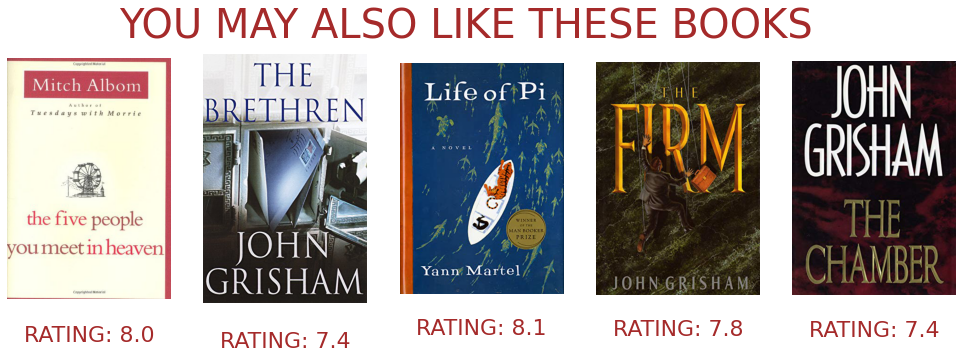

In [18]:
content_based("Tuesdays with Morrie An Old Man a Young Man and Life s Greatest Lesson")

In [19]:
content_based("A Soldier of the Great War")

No Recommendations for this Book 
 
YOU MAY TRY: 
 
Bridget Jones s Diary 

The Nanny Diaries A Novel 

She s Come Undone Oprah s Book Club Paperback 

